This notebook is setting a baseline of performance using standard metrics (e.g. total $p_T$ and multiplicity).

# Information about data

The data we are using was a part of the [ML4Jets 2021 data challenge](https://indico.cern.ch/event/980214/contributions/4413658/attachments/2278124/3870358/ml4jets_data_challenge.pdf). It is publically available in `.h5` format so it's great for doing some preliminary exploration!

**Publication:**

E. Govorkova, E. Puljak, T. Aarrestad, M. Pierini, K. A. Woźniak and J. Ngadiuba, LHC physics dataset for unsupervised New Physics detection at 40 MHz, Sci. Data 9, 118 (2022),
doi:[10.1038/s41597-022-01187-8](https://www.nature.com/articles/s41597-022-01187-8), arXiv:2107.02157

**Data:**

NOTE: The original data had several bugs in it. The links in the original materials (i.e. publication and slides) point to the incorrect Version 1 of the data. Version 2 should be used instead. [This website](https://mpp-hep.github.io/ADC2021/) contains the correct links/descriptions/usage information.

- `background_for_training.h5`: 4 million Standard Model (SM) background "training" data ([link to data](https://zenodo.org/record/5046428#.ZB9yKezMKHu))
-  `Ato4l_lepFilter_13TeV_filtered.h5`: # Neutral scalar boson events, $A \rightarrow 4l$, mass = $50$ GeV ([link to data](https://zenodo.org/record/7152590#.ZB9yROzMKHu))
- `leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5`: # Leptoquark events, ${\rm LQ} \rightarrow b \tau$ ([link to data](https://zenodo.org/record/7152599#.ZB9yZOzMKHu))
- `hToTauTau_13TeV_PU20_filtered.h5`: # Scalar boson events, $h^0 \rightarrow \tau \tau$ ([link to data](https://zenodo.org/record/7152614#.ZB9ybOzMKHt))
- `hChToTauNu_13TeV_PU20_filtered.h5`: # Charged scalar boson events, $h^\pm \rightarrow \tau \nu$ ([link to data](https://zenodo.org/record/7152617#.ZB9yf-zMKHt))
- `BlackBox_background_mix.h5`: # Mystery events ([link to data](https://zenodo.org/record/5072068#.ZB9yk-zMKHt))

In [1]:
sigAliasList    = ['sig_A', 'sig_h0', 'sig_hch', 'sig_LQ']
sigFilenameList = ['Ato4l_lepFilter_13TeV_filtered.h5', 'hToTauTau_13TeV_PU20_filtered.h5', 'hChToTauNu_13TeV_PU20_filtered.h5', 'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5']

# Google Drive preliminaries (since we're running on Google Colab)

In [2]:
#-- "Mount" Google Drive to access data and save files/images --#
# NOTE: If running locally, comment out this cell and change the basePath accordingly
# Reference: https://stackoverflow.com/questions/49031798/when-i-use-google-colaboratory-how-to-save-image-weights-in-my-google-drive
from google.colab import drive
drive.mount('/content/gdrive')

# You will be asked to sign into a Google account and give GoogleColab access

Mounted at /content/gdrive


In [3]:
# To check that mounting worked, uncomment and run the following. You should see the contents of the directory listed.
! ls '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Data/'

Ato4l_lepFilter_13TeV_filtered.h5
background_for_training.h5
BlackBox_background_mix.h5
hChToTauNu_13TeV_PU20_filtered.h5
hToTauTau_13TeV_PU20_filtered.h5
leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5
OldBuggedDatasets


In [4]:
#-- Set base directory and data directory path --#
basePath   = '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/'
dataPath   = 'Data/'

bkgPath    = basePath+dataPath+'background_for_training.h5'
sigPathList = []
for x in sigFilenameList:
  sigPathList.append(basePath+dataPath+x)

# Import libraries

We'll eventually be using the PyOT library to compute Wasserstein distances for now (see [here](https://pythonot.github.io/index.html)).

In [5]:
!pip install POT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 7.0 MB/s eta 0:00:00


In [6]:
import numpy as np
from numpy.random import RandomState
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import h5py
import ot
from numpy.random import Generator, PCG64
from sklearn import metrics
import itertools

# Functions

To keep things tidy, functions are externally defined in `centralFunctions.ipynb`. We run this notebook from here which defines the contained functions as if they were written here.


In [7]:
%cd /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/
%run centralFunctions.ipynb

/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge


# Load data

For more details on the data structure, see [this exploratory notebook](https://colab.research.google.com/drive/138CL8n4gCtramqaaI-i0EUZ7n4f1SWVh?usp=sharing).

In [8]:
dataDict = {}
dataDict['bkg'] = h5py.File(bkgPath, 'r')

for i in range(len(sigAliasList)):
  alias   = sigAliasList[i]
  sigPath = sigPathList[i]
  dataDict[alias] = h5py.File(sigPath, 'r')

# 1D particle $p_T$ and total event  $p_T$ histograms

It seems that the OT distance between distributions of particles in the $p_T$ coordinate is very distinguishing. This makes me wonder if there's a simple cut that can be done without the use of OT.

To collapse into one dimension, we'll simply make a histogram of the $p_T$ of each particle in an event ($p_{T,i}$) over all 100 events.  For example, an event with two particles $p_{T,0} = 100$ and $p_{T,1} = 50$ will each contribute 1 count to the bins containing $p_{T,i}=100$ and $p_{T,i}=50$ respectively.

In [9]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

## Make particle $p_T$ histogram

### Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

### Make plots

In [ ]:
# Prepare object data for plotting by flattening the array
# shape=(100,19) -> shape=(1900,)
pTofParticles_Bkg = scoreDict['bkgEvents1'][:, :, 0].flatten()

pTofParticles_SigList = []
for alias in sigAliasList:
  pTofParticles_SigList.append(scoreDict[alias][:, :, 0].flatten())

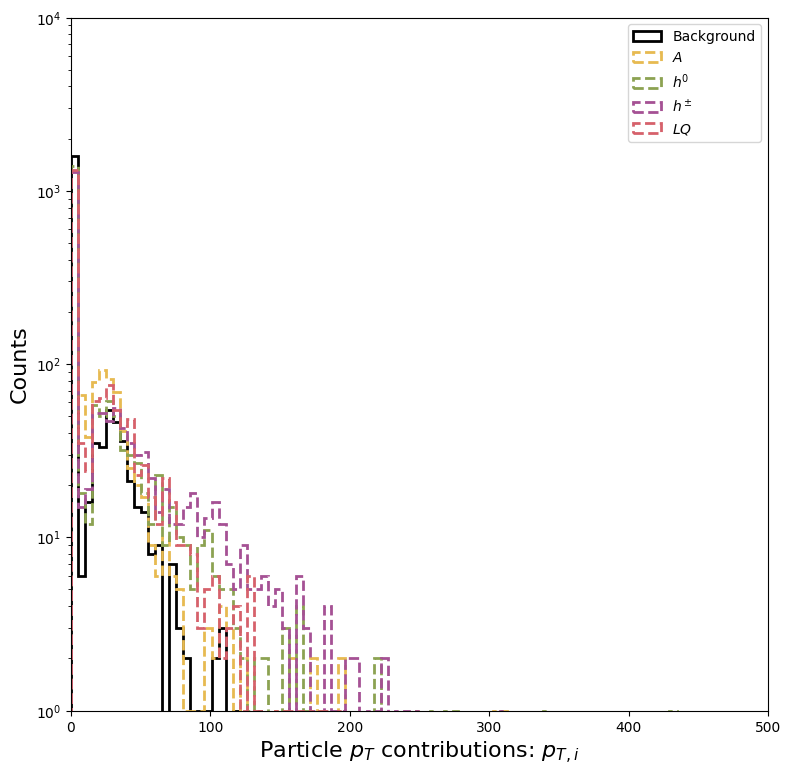

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 500)
plotArgDict['xLabel']             = r'Particle $p_{T}$ contributions: $p_{T,i}$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(pTofParticles_Bkg, pTofParticles_SigList, plotArgDict)

Let's see how well this discriminates between the classes (i.e. we'll look at the AUC values for each class).

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(pTofParticles_Bkg, pTofParticles_SigList)

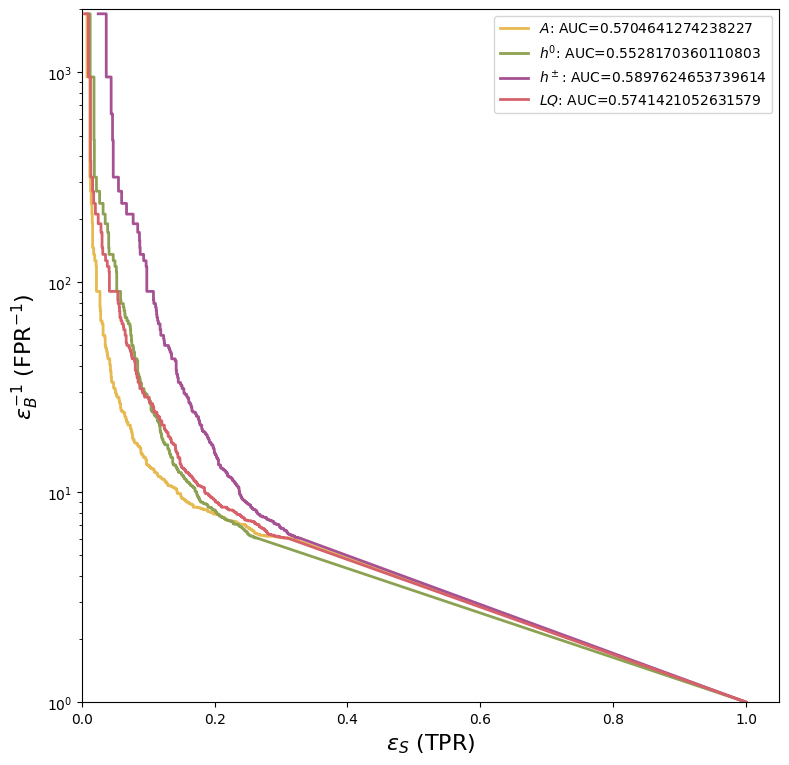

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 2e3)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r''
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

Essentially no distinguishing power.

## Make total $p_T$ histogram

### Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [10]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

### Make plots

In [11]:
# Prepare object data for plotting by flattening the array
# shape=(100,19) -> shape=(1900,)
totpT_Bkg = np.sum(scoreDict['bkgEvents1'][:, :, 0], axis=1)

totpT_SigList = []
for alias in sigAliasList:
  totpT_SigList.append(np.sum(scoreDict[alias][:, :, 0], axis=1))

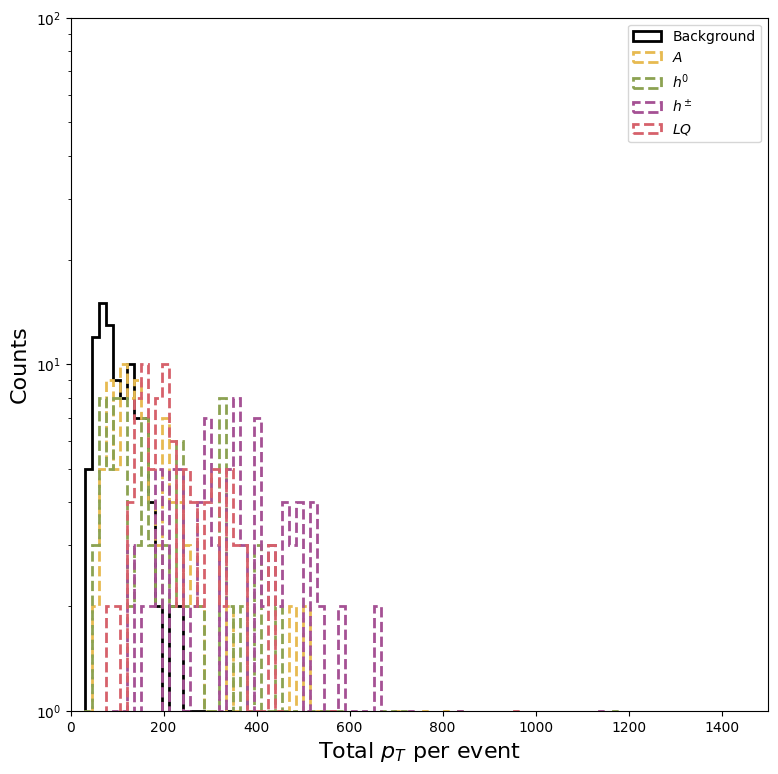

In [12]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 1500)
plotArgDict['xLabel']             = r'Total $p_{T}$ per event'
plotArgDict['yAxisLims']          = (1, 1e2)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(totpT_Bkg, totpT_SigList, plotArgDict)

### Get AUCs, ROC, and SI curves

In [13]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(totpT_Bkg, totpT_SigList)

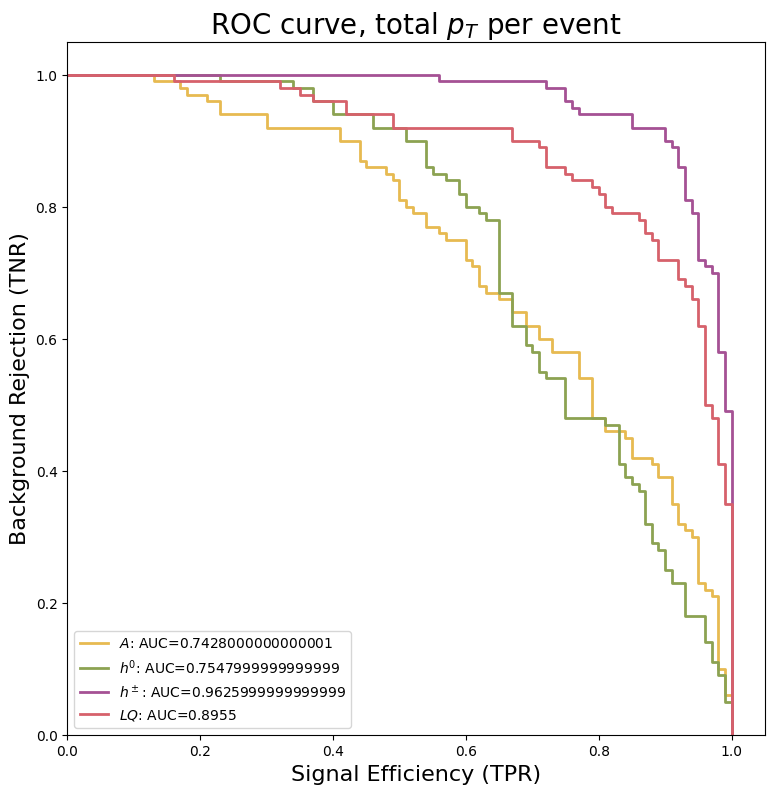

In [14]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, total $p_{T}$ per event'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

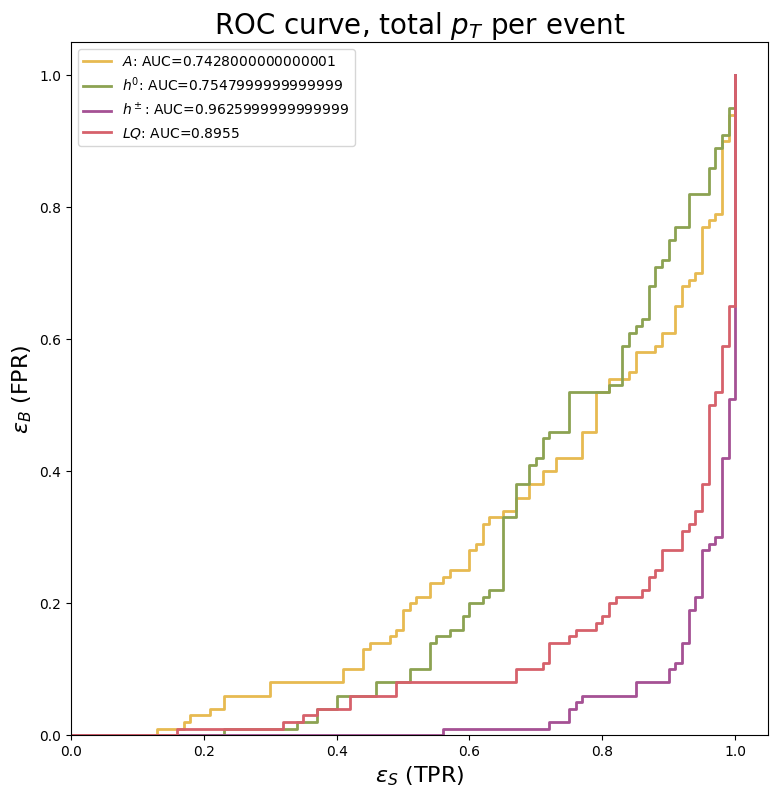

In [15]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, total $p_{T}$ per event'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

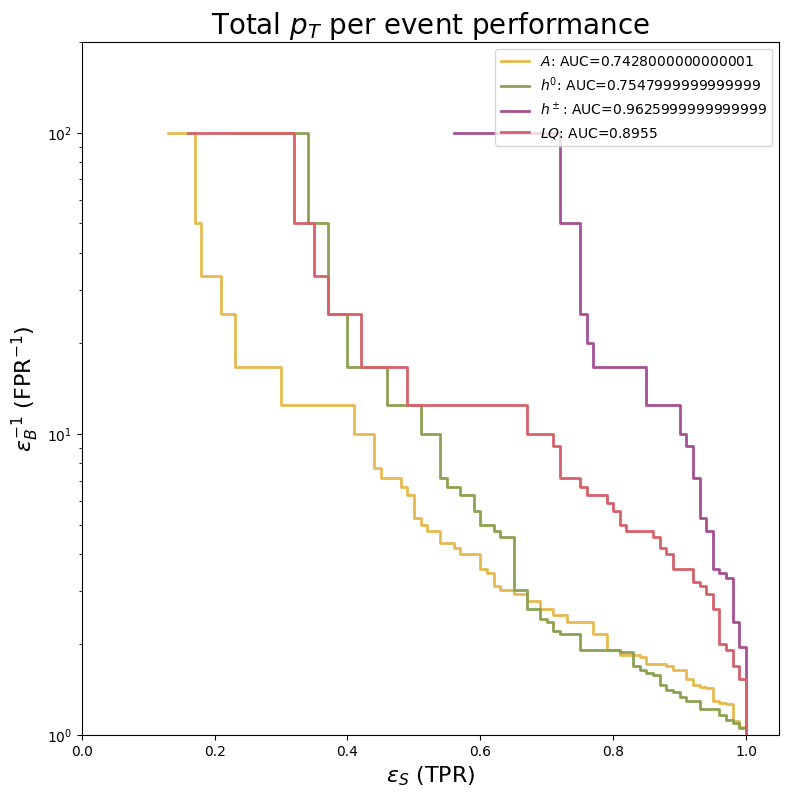

In [19]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 2e2)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'Total $p_{T}$ per event performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

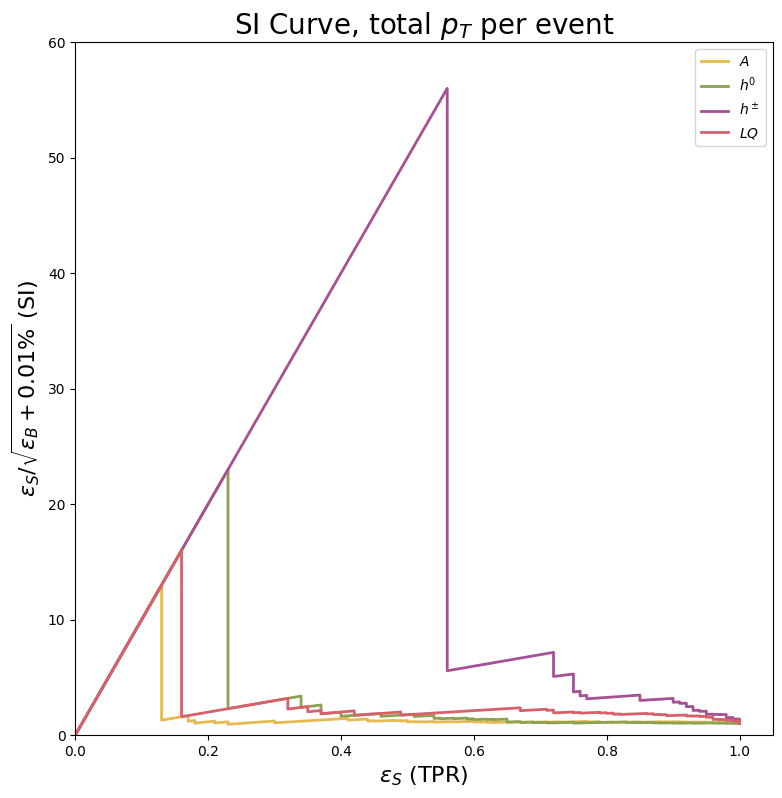

In [24]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 60)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, total $p_{T}$ per event'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

### Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [25]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [26]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.7428000000000001
     $h^0$: 0.7547999999999999
   $h^\pm$: 0.9625999999999999
      $LQ$: 0.8955


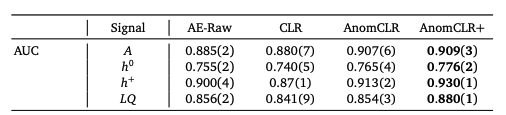

#### Inverse FPR (at TPR = 0.3):

In [27]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[12, 4, 2, 4]


In [28]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 16.666666666666668 (TPR=0.3)
     $h^0$: 100.0 (TPR=0.34)
   $h^\pm$: -- (TPR=0.56)
      $LQ$: 100.0 (TPR=0.32)


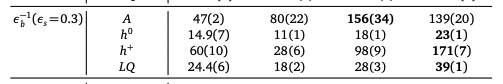

#### SI (at TPR = 0.3):

In [29]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 1.2237255246720062 (TPR=0.3)
     $h^0$: 3.383126446713963 (TPR=0.34)
   $h^\pm$: 56.00000000000001 (TPR=0.56)
      $LQ$: 3.1841190086719653 (TPR=0.32)


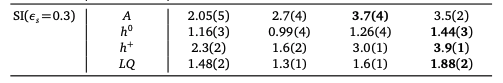